<a href="https://colab.research.google.com/github/robinjacobroy/Mathematical_symbol_classification/blob/main/math_sym_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# ```Download the data ```



In [1]:
!wget -c 'https://www.inftyproject.org/download/inftydb/InftyMDB-1.zip'

--2023-08-24 13:35:35--  https://www.inftyproject.org/download/inftydb/InftyMDB-1.zip
Resolving www.inftyproject.org (www.inftyproject.org)... 153.126.189.150
Connecting to www.inftyproject.org (www.inftyproject.org)|153.126.189.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19221789 (18M) [application/zip]
Saving to: ‘InftyMDB-1.zip’

InftyMDB-1.zip      100%[===================>]  18.33M  8.49MB/s    in 2.2s    

2023-08-24 13:35:38 (8.49 MB/s) - ‘InftyMDB-1.zip’ saved [19221789/19221789]



In [2]:
#unzip silently
!unzip InftyMDB-1.zip > /content/null.txt 2>&1

# ```Prepare the training data```

In [3]:
# Create an empty Directory to extract the training data
!rm -rf Images; mkdir Images

In [ ]:
# Extract characters from book pages

import pandas as pd
import cv2
from PIL import ImageOps
import os
from PIL import Image
import numpy as np
import csv
from tqdm import tqdm
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv("database/recognition.csv", sep =',',\
                 names= ['recres', 'num', 'x1', 'y1', 'x2', 'y2', 'matflag', 'lnktype', 'charID', 'charname', 'charcat', 'ascii' ])

Flag = True
for index, row in tqdm(df.iterrows()):

    if row.iloc[2] == "CorrectRecognition" :
        Flag = True
    elif row.iloc[2] == "Misrecognition" :
        Flag = False
    if not Flag :
        continue
    if Flag:
        if row.iloc[2] == "CorrectRecognition":
            i_num = "%04d"%row.iloc[1]
            image = np.array(Image.open(f"database/img/img{i_num}.gif"))
            continue
        else:
            posx = np.random.random()
            posy = np.random.random()
            x_init = int(row.iloc[2])
            y_init = int(row.iloc[3])
            x_fin = int(row.iloc[4])
            y_fin = int(row.iloc[5])
            char_ini = image[ y_init:y_fin, x_init:x_fin]
            _, charr = cv2.threshold(char_ini, 0, 255, cv2.THRESH_BINARY_INV\
                                     | cv2.THRESH_OTSU)
            tar_shape = (max(charr.shape[:2]),max(charr.shape[:2]))
            imp = ImageOps.pad(Image.fromarray(charr),tar_shape, \
                               method=3, color=(0), centering=(0.5,0.5))
            cv2.imwrite(f"Images/{row.iloc[9]}_{index}.png", np.array(imp))

96844it [00:38, 2539.53it/s]


In [ ]:
#Extract characters from book pages
df_corr = pd.read_csv("database/correction.csv", sep =',',\
                 names= ['recres', 'num', 'x1', 'y1', 'x2', 'y2', 'matflag', 'lnktype', 'charID', 'charname', 'charcat', 'ascii' ])

for indx, row in tqdm(df_corr.iterrows()):
    if row.iloc[2] == 'Correction':
        i_num = "%04d"%row.iloc[1]
        image = np.array(Image.open(f"database/img/img{i_num}.gif"))
        continue

    x_init = int(row.iloc[2])
    y_init = int(row.iloc[3])
    x_fin = int(row.iloc[4])
    y_fin = int(row.iloc[5])
    char_ini = image[ y_init:y_fin, x_init:x_fin]

    if 0 not in char_ini.shape:
        posx = np.random.random()#.choice([(0,0),(0.5,0.5),(1,1)])
        posy =np.random.random()
        _, charr = cv2.threshold(char_ini, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
        tar_shape = (max(charr.shape[:2]), max(charr.shape[:2]))
        imp = ImageOps.pad(Image.fromarray(charr),tar_shape,\
                           method=3, color=(0), centering=(0.5,0.5))
        index+=1
        cv2.imwrite(f"Images/{row.iloc[9]}_{index}.png", np.array(imp))

35351it [00:19, 1829.16it/s]


In [ ]:
# put each characters into respective folders
import shutil
old = None
for image in sorted(os.listdir('Images/')):
    new = image.rpartition('_')[0]

    if new != old:
        os.mkdir(f"Images/{new}")
        shutil.move(f"Images/{image}", f"Images/{new}")

    elif new == old:
        shutil.move(f"Images/{image}", f"Images/{new}")
    old = new

In [ ]:
len(os.listdir("Images/"))

231

In [ ]:
#delete directories having less than 10 images
for diry in os.listdir("Images"):
  if len(os.listdir(f"Images/{diry}"))< 10:
    shutil.rmtree(f"Images/{diry}")


In [ ]:
len(os.listdir("Images/"))

180

# ```Data Visualisation and set model hyperparametes ```

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
batch_size = 16
img_height = 28
img_width = 28
data_dir = "Images/"

In [ ]:
#split 75% of data for training
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  color_mode = "grayscale",
  batch_size=batch_size)

Found 91144 files belonging to 180 classes.
Using 68358 files for training.


In [ ]:
#remaining 25% data for validation
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="validation",
  seed=123,
  color_mode = "grayscale",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 91144 files belonging to 180 classes.
Using 22786 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['A', 'B', 'BigLeftPar', 'BigRightPar', 'C', 'D', 'Delta', 'E', 'Ext', 'F', 'G', 'Gamma', 'H', 'Hom', 'I', 'Im', 'J', 'K', 'L', 'Lambda', 'LeftPar', 'M', 'MiddleLeftPar', 'MiddleRightPar', 'N', 'O', 'Omega', 'P', 'Phi', 'Q', 'R', 'Re', 'Res', 'RightPar', 'S', 'Sigma', 'T', 'Theta', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'alpha', 'arg', 'ast', 'b', 'backslash', 'beta', 'bigcup', 'bigoplus', 'c', 'cap', 'cdot', 'cdots', 'check', 'chi', 'circ', 'colon', 'comma', 'cong', 'cup', 'd', 'deg', 'delta', 'det', 'dim', 'dot', 'doubleprime', 'e', 'eight', 'epsilon', 'equal', 'equiv', 'eta', 'exclamation', 'exp', 'f', 'five', 'four', 'frac', 'g', 'gamma', 'geq', 'geqq', 'greater', 'h', 'hat', 'i', 'in', 'infinity', 'int', 'iota', 'j', 'k', 'l', 'lambda', 'langle', 'ldots', 'leq', 'leqq', 'less', 'lim', 'ln', 'log', 'm', 'mapsto', 'max', 'min', 'minus', 'mu', 'n', 'nabla', 'neg', 'nine', 'notequal', 'notin', 'nu', 'o', 'omega', 'one', 'oplus', 'otimes', 'overline', 'p', 'partial', 'period', 'perp', 'phi

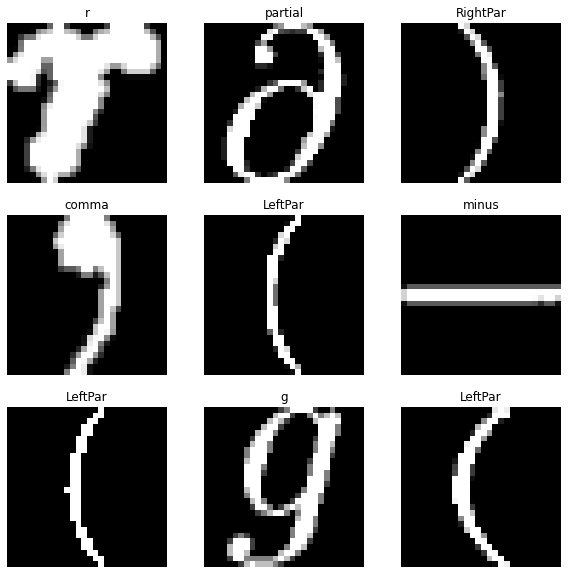

In [ ]:
#Visualise some images in the taining set
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(images[i]).astype("uint8"), cmap= 'gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 28, 28, 1)
(16,)


In [ ]:
#settings for memory optimisation
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Optional cell for data augmentation using random translations
"""data_augmentation = keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomTranslation(
    height_factor=0.05,
    width_factor=0.05,
    fill_mode='constant',
    interpolation="bilinear",
    fill_value =255,
    input_shape = (img_height,img_width,1)),
  ]
)
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    #print(augmented_images[0].numpy().shape)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8")[:,:,0], cmap = "gray")
    plt.axis("off")
""";

In [ ]:
#define the model
num_classes = len(os.listdir("Images"))   #180

model = Sequential([

  layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height,img_width,1) ),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(64, activation='relu',kernel_initializer='he_uniform'),
  layers.Dropout(0.2),
  #layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)               

In [ ]:
# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9)
model.compile(optimizer=sgd,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callback]
)

Epoch 1/15
4273/4273 [==============================] - 22s 5ms/step - loss: 0.9124 - accuracy: 0.8009 - val_loss: 0.1142 - val_accuracy: 0.9676
Epoch 2/15
4273/4273 [==============================] - 21s 5ms/step - loss: 0.1492 - accuracy: 0.9557 - val_loss: 0.0936 - val_accuracy: 0.9715
Epoch 3/15
4273/4273 [==============================] - 22s 5ms/step - loss: 0.1165 - accuracy: 0.9657 - val_loss: 0.0893 - val_accuracy: 0.9733
Epoch 4/15
4273/4273 [==============================] - 21s 5ms/step - loss: 0.0993 - accuracy: 0.9687 - val_loss: 0.0845 - val_accuracy: 0.9753
Epoch 5/15
4273/4273 [==============================] - 21s 5ms/step - loss: 0.0906 - accuracy: 0.9715 - val_loss: 0.0820 - val_accuracy: 0.9758
Epoch 6/15
4273/4273 [==============================] - 22s 5ms/step - loss: 0.0849 - accuracy: 0.9732 - val_loss: 0.0934 - val_accuracy: 0.9715
Epoch 7/15
4273/4273 [==============================] - 22s 5ms/step - loss: 0.0804 - accuracy: 0.9733 - val_loss: 0.0798 - val_ac

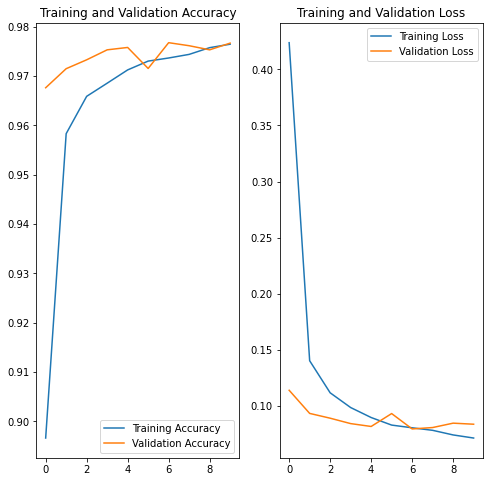

In [ ]:
#Visualise the model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(callback.stopped_epoch+1)#range(epochs)#

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [4]:
#Download and preprocess the test image...

!wget -O integral.png  "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fi.pinimg.com%2F736x%2Fba%2F55%2Fd2%2Fba55d2328aada2c9176c30eb7c50e0ee--science-art-symbols.jpg&f=1&nofb=1"
import cv2, numpy as np
from PIL import ImageOps, Image

img = cv2.imread("integral.png",0)
_, img_array = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
indices = np.where(img_array == 255)
ini = (np.max(indices[1]),np.min(indices[0]))
fin = (np.min(indices[1]),np.max(indices[0]))
imd = img_array[ini[1]:fin[1], fin[0]:ini[0]]
tar_shape = (max(imd.shape[:2]), max(imd.shape[:2]))
imp = np.array(ImageOps.pad(Image.fromarray(imd),tar_shape,\
                           method=3, color=(0), centering=(0.5,0.5)))
cv2.imwrite("integral1.png", imp)

--2023-08-24 13:39:15--  https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fi.pinimg.com%2F736x%2Fba%2F55%2Fd2%2Fba55d2328aada2c9176c30eb7c50e0ee--science-art-symbols.jpg&f=1&nofb=1
Resolving external-content.duckduckgo.com (external-content.duckduckgo.com)... 40.89.244.234
Connecting to external-content.duckduckgo.com (external-content.duckduckgo.com)|40.89.244.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘integral.png’

integral.png            [ <=>                ]   8.12K  --.-KB/s    in 0s      

2023-08-24 13:39:15 (195 MB/s) - ‘integral.png’ saved [8311]



True

In [ ]:
#testing on unseen image
classes = np.array(class_names)

path = tf.keras.utils.get_file('symbol', origin="https://i.stack.imgur.com/vqKoE.png")

img = keras.preprocessing.image.load_img(
    "integral1.png", target_size=(img_height, img_width), color_mode = "grayscale"
)
img_array = keras.preprocessing.image.img_to_array(img)
#_, img_array = cv2.threshold(img_array, 127, 255, cv2.THRESH_BINARY_INV)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
top = np.argsort(predictions[0])[:-5:-1]
for i in range(len(top)):
    print("{}".format(classes[top[i]])+" ({:.3})".format(score[top[i]]))


int (1.0)
f (0.000204)
slash (4.53e-07)
J (3.87e-07)


In [ ]:
model.save("good_model.h5")
!ls

database      equation.png   Images	     integral1.png  null.txt
download.png  good_model.h5  InftyMDB-1.zip  integral.png   sample_data


[]
l (0.994)... second option vert (0.00377)


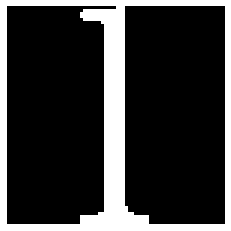

l (0.994)... second option vert (0.00377)


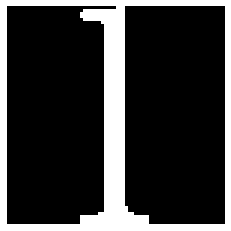

one (1.0)... second option l (6.25e-06)


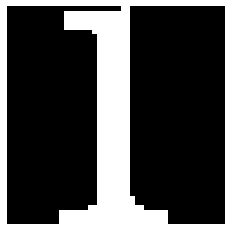

m (1.0)... second option Im (1.42e-10)


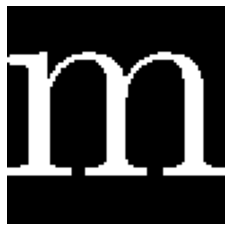

one (1.0)... second option l (6.25e-06)


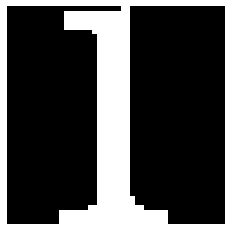

m (1.0)... second option Im (1.42e-10)


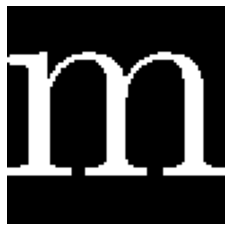

rightarrow (1.0)... second option vec (3.93e-07)


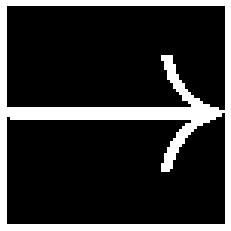

x (1.0)... second option chi (5.3e-09)


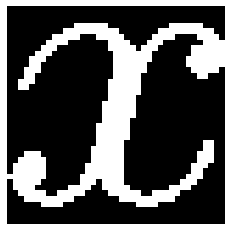

infinity (1.0)... second option supset (2.02e-06)


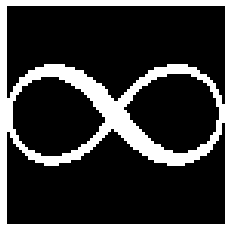

rightarrow (1.0)... second option vec (3.93e-07)


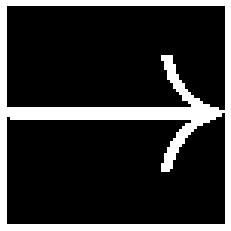

x (1.0)... second option chi (5.3e-09)


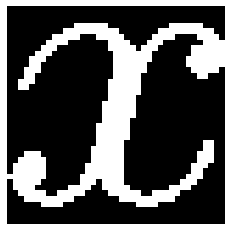

infinity (1.0)... second option supset (2.02e-06)


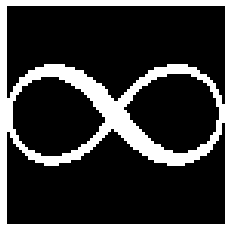

In [ ]:
#Prediction using connected component analysis

import cv2
import numpy as np
from PIL import ImageOps, Image
import statistics
from skimage import io
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

classes = np.array(['A', 'B', 'BigLeftPar', 'BigRightPar', 'C', 'D', 'Delta', 'E', 'Ext', 'F', 'G', 'Gamma', 'H', 'Hom', 'I', 'Im', 'J', 'K', 'L', 'Lambda', 'LeftPar', 'M',
                    'MiddleLeftPar', 'MiddleRightPar', 'N', 'O', 'Omega', 'P', 'Phi', 'Q', 'R', 'Re', 'Res', 'RightPar', 'S', 'Sigma', 'T', 'Theta', 'U', 'V', 'W', 'X', 'Y', 'Z',
                    'a', 'alpha', 'arg', 'ast', 'b', 'backslash', 'beta', 'bigcup', 'bigoplus', 'c', 'cap', 'cdot', 'cdots', 'check', 'chi', 'circ', 'colon', 'comma', 'cong',
                    'cup', 'd', 'deg', 'delta', 'det', 'dim', 'dot', 'doubleprime', 'e', 'eight', 'epsilon', 'equal', 'equiv', 'eta', 'exclamation', 'exp', 'f', 'five', 'four',
                    'frac', 'g', 'gamma', 'geq', 'geqq', 'greater', 'h', 'hat', 'i', 'in', 'infinity', 'int', 'iota', 'j', 'k', 'l', 'lambda', 'langle', 'ldots', 'leq', 'leqq', 'less',
                    'lim', 'ln', 'log', 'm', 'mapsto', 'max', 'min', 'minus', 'mu', 'n', 'nabla', 'neg', 'nine', 'notequal', 'notin', 'nu', 'o', 'omega', 'one', 'oplus',
                    'otimes', 'overline', 'p', 'partial', 'period', 'perp', 'phi', 'pi', 'plus', 'pm', 'prec', 'prime', 'prod', 'psi', 'q', 'r', 'rangle', 'rho', 'rightarrow',
                    's', 'semicolon', 'seven', 'sigma', 'sim', 'six', 'slash', 'sqrt', 'subset', 'sum', 'sup', 'supset', 't', 'tau', 'theta', 'three', 'tilde', 'times', 'two',
                    'u', 'underline', 'v', 'varepsilon', 'varliminf', 'varlimsup', 'varphi', 'varrho', 'vec', 'vert', 'w', 'wedge', 'x', 'xi', 'y', 'z', 'zero', 'zeta'])
model1 = keras.models.load_model("good_model.h5")
url="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fi.stack.imgur.com%2Fjg6fe.png&f=1&nofb=1"
img = io.imread(url)
#image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
image = img.copy()#cv2.imread("download.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255,
    cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
output = cv2.connectedComponentsWithStats(thresh, 4, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output
areas = [stats[i, cv2.CC_STAT_AREA] for i in range(1, numLabels) ]
th_area = statistics.median(areas)/4
x_vals = centroids[:,0]
uniques, uniq_idx, counts = np.unique(x_vals,return_index=True,return_counts=True)
dbls = x_vals[ uniq_idx[counts>=2] ]
dbl_index = np.array([(np.where(x_vals == i)[0]) for i in dbls])
print(dbl_index)
#iterating over the connected components
for i in range(1, numLabels):

    area = stats[i, cv2.CC_STAT_AREA]
    #ignore if the current component area is less than the threshold area
    if area < th_area:
        #print("area = ", area)
        continue

    #in case of equal and equality symbols
    if len(dbl_index):
      if i in dbl_index[:,0]:
          for indx in np.where(dbl_index==i):
            j = dbl_index[indx[0]]
            x1 = stats[j[0], cv2.CC_STAT_LEFT]
            y1 = stats[j[0], cv2.CC_STAT_TOP]
            x2 = stats[j[1], cv2.CC_STAT_LEFT]
            y2 = stats[j[1], cv2.CC_STAT_TOP]
            w = stats[j[1], cv2.CC_STAT_WIDTH]
            h = stats[j[1], cv2.CC_STAT_HEIGHT]
            crop = thresh[y1:y2+h, x1:x2+w]

    elif i in dbl_index:
        continue
    #for unique symbols
    else:
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        crop = thresh[y:y+h, x:x+w]
    tar_shape = (max(crop.shape[:2]), max(crop.shape[:2]))
    imp = np.array(ImageOps.pad(Image.fromarray(crop),tar_shape,\
                           method=3, color=(0), centering=(0.5,0.5)))
    img_array = tf.expand_dims(cv2.resize(imp,(28,28)), 0) # Create a batch

    predictions = model1.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    top = np.argsort(predictions[0])[:-3:-1]

    print("{}".format(classes[top[0]])+" ({:.3})".format(score[top[0]])\
          +"... second option "+ "{}".format(classes[top[1]])+" ({:.3})".format(score[top[1]]))
    plt.axis("off")
    plt.imshow(imp, cmap = "gray")
    plt.show()


In [ ]:
# function to crop characters using the in-between blank space

def crop_chars(disp):

    chars = []
    for num, i in enumerate(disp[0,:]):
        if not np.all(~disp[:, num]):
            chars.append(num)
    chars = np.array(chars)
    stop = np.where(abs(np.diff(chars))>1)[0]
    start = np.where(abs(np.diff(chars))>1)[0]+1
    sy_stop = chars[stop]
    sy_start = chars[start]
    for i in range(len(sy_stop)+1):
        if i==0:
            out = disp[:, chars[0]:sy_stop[0]+1]
        elif i == len(sy_stop):
            out = disp[:, sy_start[-1]:chars[-1]+1]
        else:
            out = disp[:, sy_start[i-1]:sy_stop[i]+1]

        crop_indi = np.where(out== 255)

        min_x = min(crop_indi[0])
        max_x = max(crop_indi[0])

        if min_x == 0:
            output = out[min_x:max_x+1,:]
        else:
            output = out[min_x-1:max_x+1,:]
        if 0 in output.shape :
            continue
        tar_shape = (max(output.shape[:2]), max(output.shape[:2]))
        imp = np.array(ImageOps.pad(Image.fromarray(output),tar_shape,\
                           method=3, color=(0), centering=(0.5,0.5)))

        img_array = tf.expand_dims(cv2.resize(imp,(28,28)), 0) # Create a batch

        predictions = model1.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        top = np.argsort(predictions[0])[:-3:-1]

        print("{}".format(classes[top[0]])+" ({:.3})".format(score[top[0]])\
              +"... second option --> "+ "{}".format(classes[top[1]])+" ({:.3})".format(score[top[1]]))
        plt.axis("off")
        plt.imshow(imp, cmap = "gray")
        plt.show()

semicolon (0.483)... second option --> xi (0.158)


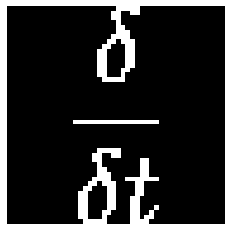

p (1.0)... second option --> P (1.48e-06)


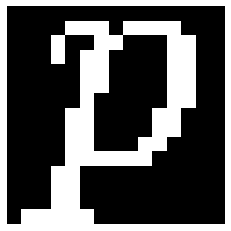

LeftPar (1.0)... second option --> BigLeftPar (1.82e-07)


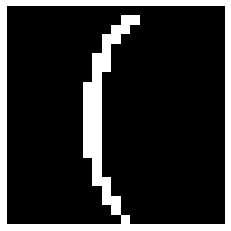

Z (0.955)... second option --> z (0.039)


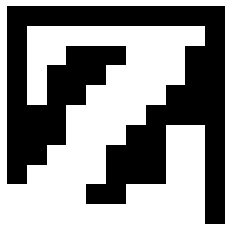

comma (0.901)... second option --> one (0.0433)


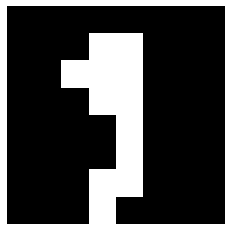

t (1.0)... second option --> i (3.08e-05)


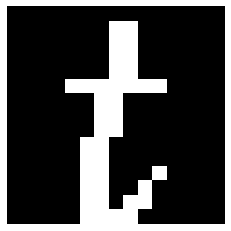

RightPar (1.0)... second option --> rangle (5.82e-08)


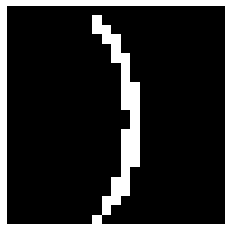

equal (1.0)... second option --> Ext (1.77e-05)


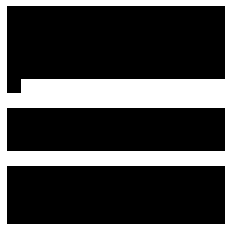

minus (0.797)... second option --> frac (0.107)


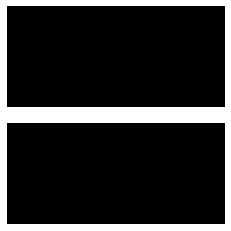

sum (0.411)... second option --> f (0.231)


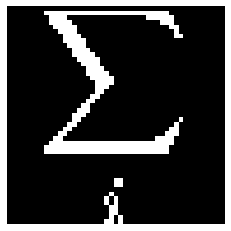

lambda (0.573)... second option --> one (0.246)


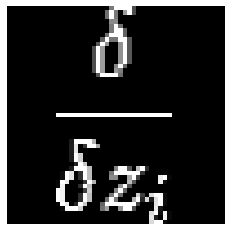

BigLeftPar (1.0)... second option --> LeftPar (4.85e-05)


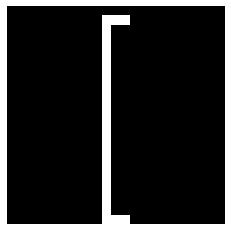

A (1.0)... second option --> Lambda (3.68e-05)


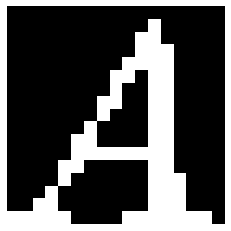

i (1.0)... second option --> five (8.2e-05)


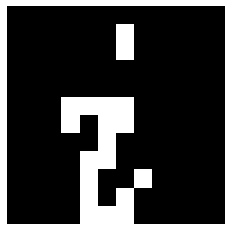

LeftPar (1.0)... second option --> BigLeftPar (1.82e-07)


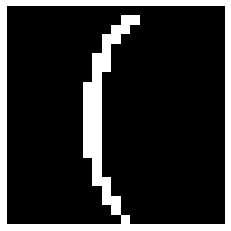

Z (0.955)... second option --> z (0.039)


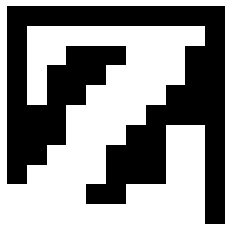

comma (0.762)... second option --> one (0.18)


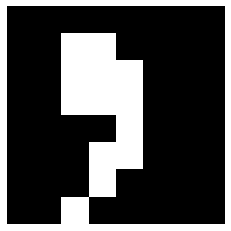

t (1.0)... second option --> i (3.08e-05)


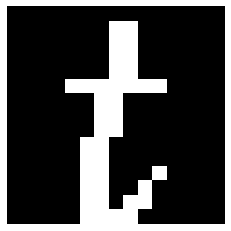

RightPar (1.0)... second option --> rangle (5.82e-08)


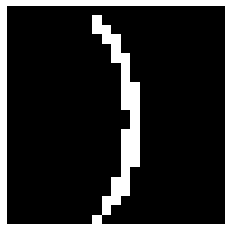

p (1.0)... second option --> P (1.48e-06)


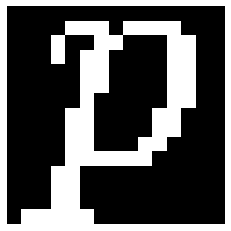

LeftPar (1.0)... second option --> BigLeftPar (1.82e-07)


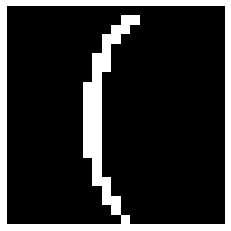

Z (0.955)... second option --> z (0.039)


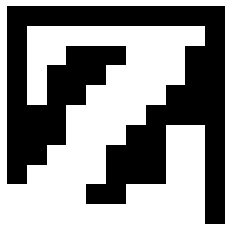

comma (0.762)... second option --> one (0.18)


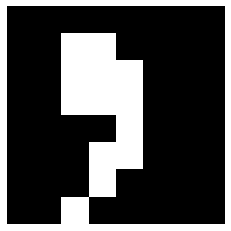

t (1.0)... second option --> i (3.08e-05)


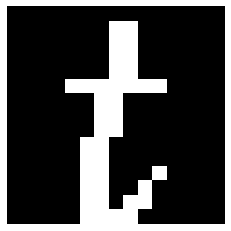

RightPar (1.0)... second option --> rangle (5.82e-08)


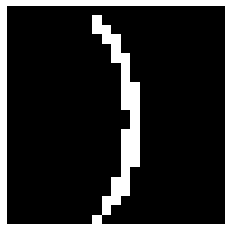

BigRightPar (0.998)... second option --> l (0.00139)


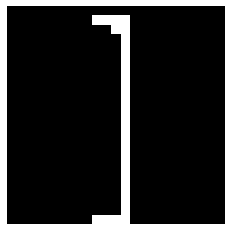

plus (0.981)... second option --> vert (0.0111)


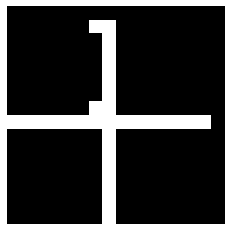

notequal (0.284)... second option --> varphi (0.261)


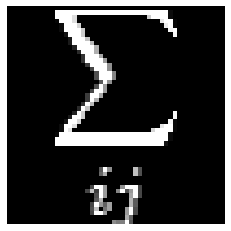

MiddleRightPar (0.634)... second option --> semicolon (0.27)


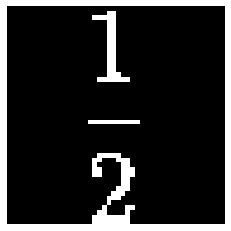

notin (0.405)... second option --> lambda (0.156)


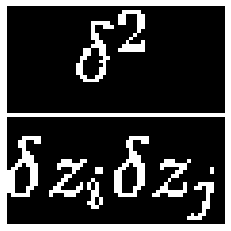

BigLeftPar (1.0)... second option --> LeftPar (4.85e-05)


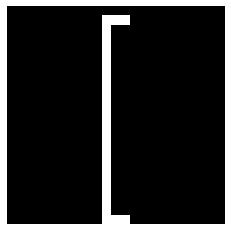

log (0.978)... second option --> lambda (0.0104)


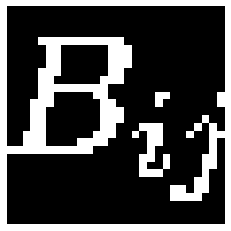

LeftPar (1.0)... second option --> BigLeftPar (1.82e-07)


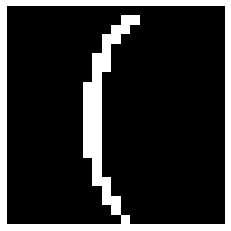

Z (0.946)... second option --> two (0.0332)


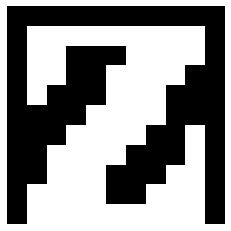

comma (0.762)... second option --> one (0.18)


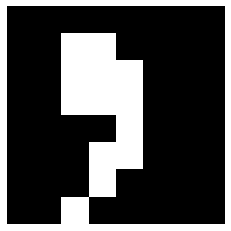

t (1.0)... second option --> iota (0.000136)


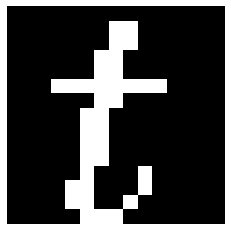

RightPar (1.0)... second option --> rangle (5.82e-08)


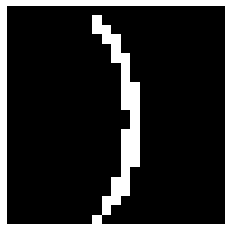

p (1.0)... second option --> P (1.48e-06)


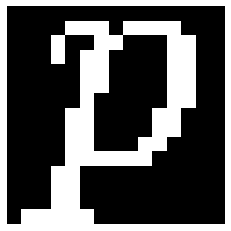

LeftPar (1.0)... second option --> BigLeftPar (1.18e-07)


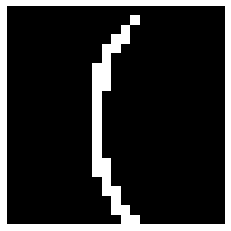

Z (0.946)... second option --> two (0.0332)


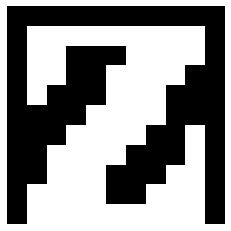

comma (0.762)... second option --> one (0.18)


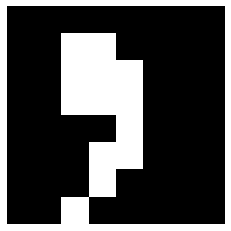

t (1.0)... second option --> iota (0.000136)


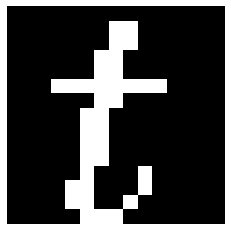

RightPar (1.0)... second option --> rangle (5.82e-08)


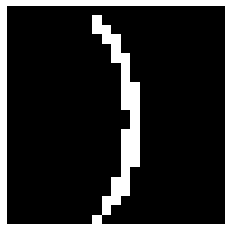

BigRightPar (1.0)... second option --> l (0.000253)


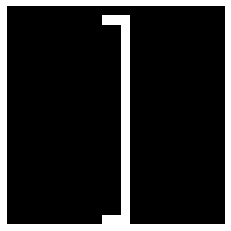

plus (0.981)... second option --> vert (0.0111)


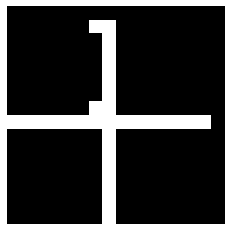

one (0.257)... second option --> iota (0.194)


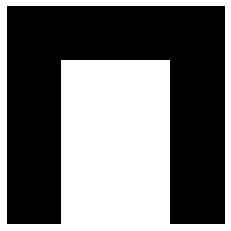

slash (0.995)... second option --> f (0.00387)


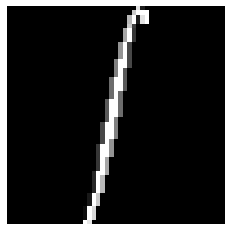

d (1.0)... second option --> l (8.46e-05)


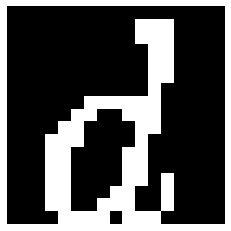

Y (0.873)... second option --> Gamma (0.0316)


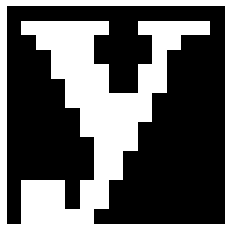

BigLeftPar (1.0)... second option --> LeftPar (4.85e-05)


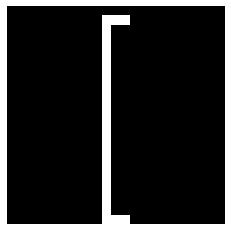

W (1.0)... second option --> w (4.78e-05)


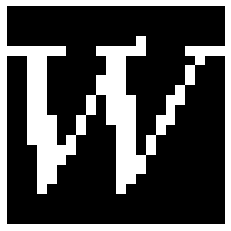

LeftPar (1.0)... second option --> BigLeftPar (1.82e-07)


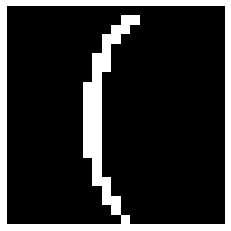

Z (0.955)... second option --> z (0.039)


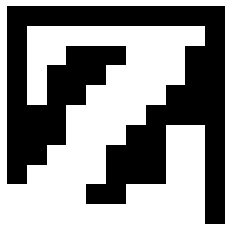

vert (0.999)... second option --> MiddleLeftPar (0.000243)


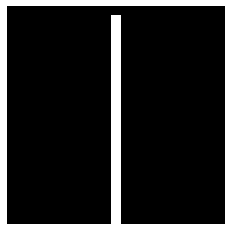

y (0.313)... second option --> gamma (0.216)


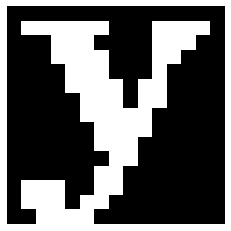

comma (0.901)... second option --> one (0.0433)


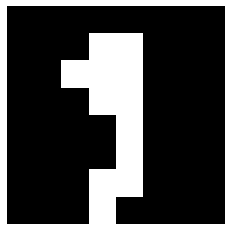

t (1.0)... second option --> iota (0.000136)


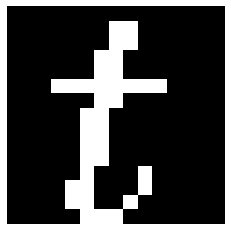

RightPar (0.99)... second option --> rangle (0.0094)


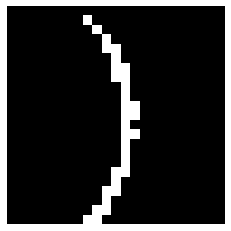

p (0.999)... second option --> rho (0.00055)


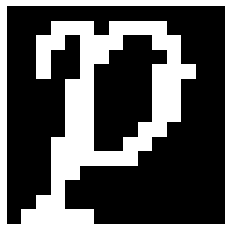

LeftPar (1.0)... second option --> BigLeftPar (1.18e-07)


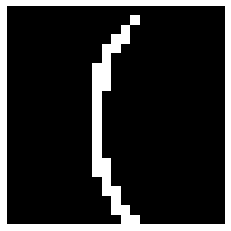

Z (0.946)... second option --> two (0.0332)


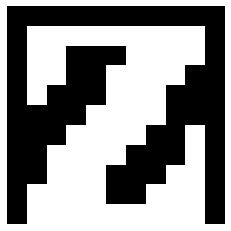

comma (0.901)... second option --> one (0.0433)


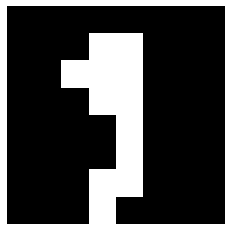

t (1.0)... second option --> iota (0.000136)


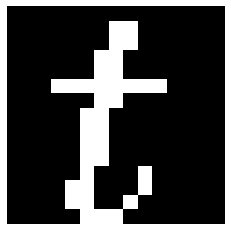

RightPar (0.99)... second option --> rangle (0.0094)


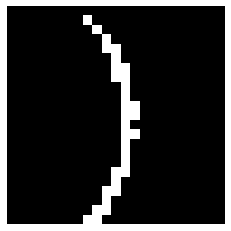

minus (0.753)... second option --> frac (0.128)


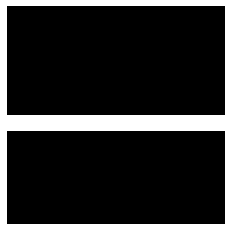

W (0.999)... second option --> N (0.000738)


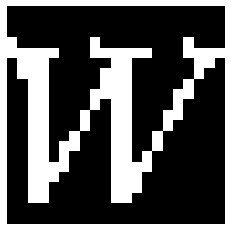

LeftPar (1.0)... second option --> BigLeftPar (1.82e-07)


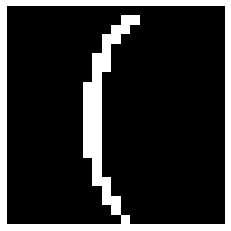

Y (0.873)... second option --> Gamma (0.0316)


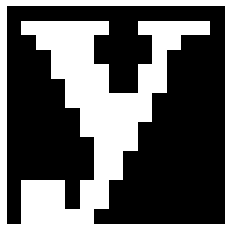

vert (0.999)... second option --> MiddleRightPar (0.000299)


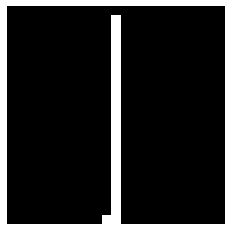

Z (0.955)... second option --> z (0.039)


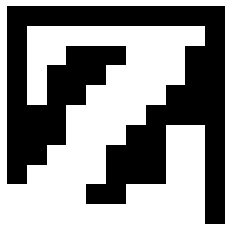

comma (0.901)... second option --> one (0.0433)


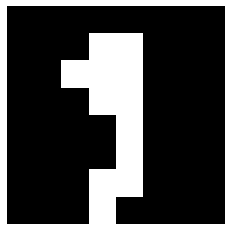

t (1.0)... second option --> i (3.08e-05)


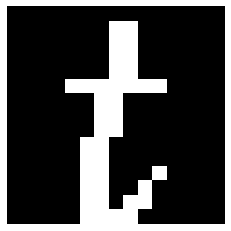

RightPar (1.0)... second option --> rangle (5.82e-08)


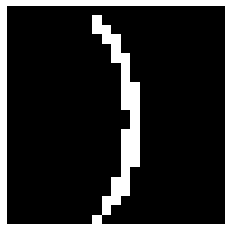

p (1.0)... second option --> P (1.48e-06)


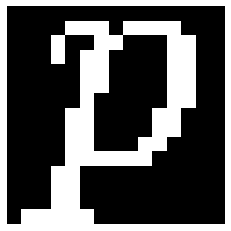

LeftPar (1.0)... second option --> BigLeftPar (1.82e-07)


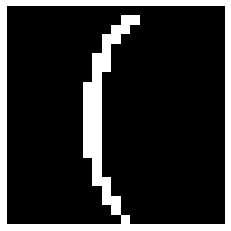

Z (0.955)... second option --> z (0.039)


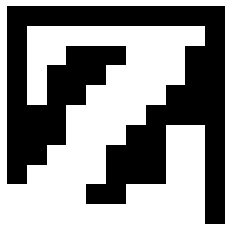

comma (0.901)... second option --> one (0.0433)


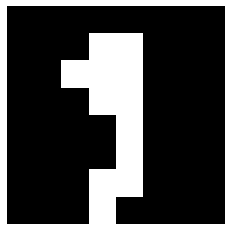

t (1.0)... second option --> i (3.08e-05)


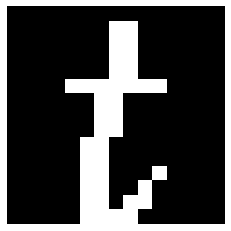

RightPar (1.0)... second option --> rangle (5.82e-08)


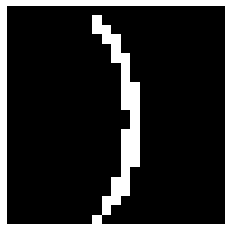

BigRightPar (0.998)... second option --> l (0.00139)


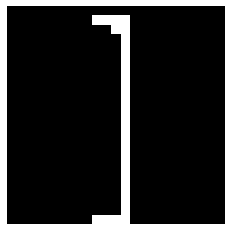

LeftPar (1.0)... second option --> BigLeftPar (7.61e-06)


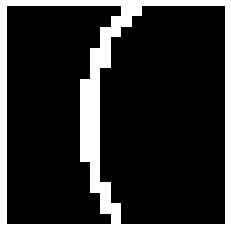

one (1.0)... second option --> l (2.26e-06)


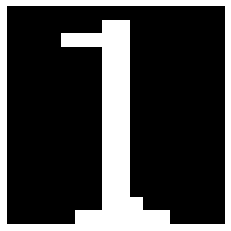

RightPar (1.0)... second option --> MiddleRightPar (1.7e-07)


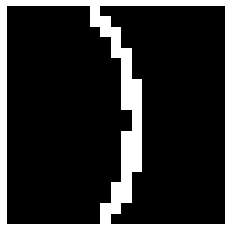

In [ ]:
#prediction using image slicing with blank spaces
import cv2
import numpy as np
from PIL import ImageOps, Image
import statistics
from skimage import io
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

classes = np.array(['A', 'B', 'BigLeftPar', 'BigRightPar', 'C', 'D', 'Delta', 'E',
                    'Ext', 'F', 'G', 'Gamma', 'H', 'Hom', 'I', 'Im', 'J', 'K', 'L',
                    'Lambda', 'LeftPar', 'M', 'MiddleLeftPar', 'MiddleRightPar',
                    'N', 'O', 'Omega', 'P', 'Phi', 'Q', 'R', 'Re', 'Res', 'RightPar',
                    'S', 'Sigma', 'T', 'Theta', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a',
                    'alpha', 'arg', 'ast', 'b', 'backslash', 'beta', 'bigcup',
                    'bigoplus', 'c', 'cap', 'cdot', 'cdots', 'check', 'chi', 'circ',
                    'colon', 'comma', 'cong', 'cup', 'd', 'deg', 'delta', 'det',
                    'dim', 'dot', 'doubleprime', 'e', 'eight', 'epsilon', 'equal',
                    'equiv', 'eta', 'exclamation', 'exp', 'f', 'five', 'four', 'frac',
                    'g', 'gamma', 'geq', 'geqq', 'greater', 'h', 'hat', 'i', 'in',
                    'infinity', 'int', 'iota', 'j', 'k', 'l', 'lambda', 'langle',
                    'ldots', 'leq', 'leqq', 'less', 'lim', 'ln', 'log', 'm', 'mapsto',
                    'max', 'min', 'minus', 'mu', 'n', 'nabla', 'neg', 'nine', 'notequal',
                    'notin', 'nu', 'o', 'omega', 'one', 'oplus', 'otimes', 'overline',
                    'p', 'partial', 'period', 'perp', 'phi', 'pi', 'plus', 'pm', 'prec',
                    'prime', 'prod', 'psi', 'q', 'r', 'rangle', 'rho', 'rightarrow',
                    's', 'semicolon', 'seven', 'sigma', 'sim', 'six', 'slash', 'sqrt',
                    'subset', 'sum', 'sup', 'supset', 't', 'tau', 'theta', 'three',
                    'tilde', 'times', 'two', 'u', 'underline', 'v', 'varepsilon',
                    'varliminf', 'varlimsup', 'varphi', 'varrho', 'vec', 'vert',
                    'w', 'wedge', 'x', 'xi', 'y', 'z', 'zero', 'zeta'])
model1 = keras.models.load_model("good_model.h5")

url="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fi.stack.imgur.com%2Fjg6fe.png&f=1&nofb=1"
#image = io.imread(url)

image = cv2.imread("download.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255,
    cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

eqn_line = []
for num, i in enumerate(thresh[:,0]):
    if not np.all(~thresh[num,:]):
        eqn_line.append(num)
eqn_line = np.array(eqn_line)
stop = np.where(abs(np.diff(eqn_line))>1)[0]
start = np.where(abs(np.diff(eqn_line))>1)[0]+1
sy_stop = eqn_line[stop]
sy_start = eqn_line[start]

if len(start):
  for i in range(len(sy_start)+1):
    if i==0:

        out = thresh[eqn_line[0]:sy_stop[0],:]
    elif i == len(sy_stop):
        out = thresh[sy_start[-1]:eqn_line[-1],:]
    else:

        out = thresh[sy_start[i-1]:sy_stop[i],:]
    crop_chars(out)
else:
  crop_chars(thresh)


In [ ]:
model.save("good_model.h5")

In [ ]:
model1 = keras.models.load_model("good_model.h5")

In [ ]:
!tar -czvf Images.tar.gz Images/